# Polygon drill <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** 
A shape file containing the polygon you would like to use for the analysis. Here we use ACT suburb boundaries, available as a [shapefile from data.gov.au](https://www.data.gov.au/dataset/ds-dga-0257a9da-b558-4d86-a987-535c775cf8d8/details?q=).

## Description
A polygon drill can be used to grab a stack of imagery that corresponds to the location of an input polygon. 
It is a useful tool for generating animations, or running analyses over a range of imagery.

This notebook shows you how to:

1. Use a polygon's geometry to generate a `dc.load` query
2. Mask the returned data with the polygon geometry (to remove unwanted pixels)
3. Plot a time step from the imagery stack to check it has been loaded as expected

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import geopandas as gpd
from datacube.utils import geometry

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_spatialtools import xr_rasterize

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Polygon_drill')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `polygon_to_drill`: The path containing the polygon to use for the polygon drill. 
If it's a local polygon, then this parameter is the local path to that polygon. 
If it's located online, then this is the path to the online location of the polygon.
* `time_to_drill`: e.g. `('2016-01-01', '2016-06-30')`.
The time over which we want to run the polygon drill, entered as a tuple.


In [3]:
polygon_to_drill = 'https://data.gov.au/data/dataset/0257a9da-b558-4d86-a987-535c775cf8d8/resource/d9100544-182d-470c-b3b2-75812322c495/download/act_locality_polygon_shp.zip'
time_to_drill = ('2016-02', '2016-03')

## Load up the shapefile we want to use for the polygon drill

In [4]:
# Use code comments for low-level documentation of code
polygon_to_drill = gpd.read_file(polygon_to_drill)

In [5]:
# Check that the polygon loaded as expected. We'll just print the first 3 rows to check
polygon_to_drill.head(3)

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,NAME,POSTCODE,PRIM_PCODE,LOCCL_CODE,DT_GAZETD,STATE_PID,geometry
0,16867,2020-06-11,None,ACT616,GORDON,None,None,G,None,8,"POLYGON ((149.09087 -35.46410, 149.09080 -35.4..."
1,16817,2020-06-11,None,ACT607,RICHARDSON,None,None,G,None,8,"POLYGON ((149.10331 -35.42082, 149.10338 -35.4..."
2,16950,2020-06-11,None,ACT916,HALL,None,9999,D,None,8,"POLYGON ((149.04621 -35.16871, 149.06241 -35.1..."


## Query the datacube using the polygon we have loaded

### Set up the `dc.load` query

We need to grab the geometry from the polygon we want to use for the polygon drill. 
For this example, we'll just grab the first polygon from the file using `.iloc[0]`:

In [6]:
geom = geometry.Geometry(geom=polygon_to_drill.iloc[0].geometry, 
                         crs=polygon_to_drill.crs)

To set up the query, we need to specify a few parameters:

- `'geopolygon'`: Here we input the geometry we want to use for the drill that we prepared in the cell above
- `'time'`: Feed in the `time_to_drill` parameter we set earlier
- `'output_crs'`: We need to specify the coordinate reference scheme of the output. 
We'll use Albers Equal Area projection for Australia
- `'resolution'`: You can choose the resolution of the output dataset. 
Since Landsat 8 is 30 m resolution, we'll just use that
- `'measurements'`: Here is where you specify which bands you want to extract. 
We will just be plotting a true colour image, so we just need red, green and blue.

In [7]:
query = {'geopolygon': geom,
         'time': time_to_drill,
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30),
         'measurements': ['nbart_red', 
                          'nbart_green', 
                          'nbart_blue']
        }

### Use the query to extract data

Here we have hard coded extraction from Landsat 8 by supplying `product='ga_ls8c_ard_3'`, but this can be changed depending on your requirements.

We can verify that the polygon drill has loaded a time series of satellite data by checking the `Dimensions` of the resulting `xarray.Dataset`.
In this example, we can see that the polygon drill has loaded 7 time steps (i.e. `Dimensions: time: 7`):

In [8]:
# Load data for our polygon and time period
data = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)

# Check we have some data back with multiple timesteps
data

<xarray.Dataset>
Dimensions:      (time: 7, x: 74, y: 139)
Coordinates:
  * time         (time) datetime64[ns] 2016-02-06T23:50:42.733900 ... 2016-03...
  * y            (y) float64 -3.974e+06 -3.974e+06 ... -3.978e+06 -3.978e+06
  * x            (x) float64 1.543e+06 1.543e+06 ... 1.545e+06 1.545e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) int16 804 778 742 696 682 ... 1019 1164 1022 1110
    nbart_green  (time, y, x) int16 740 721 701 667 645 ... 768 957 1007 888 896
    nbart_blue   (time, y, x) int16 462 448 440 414 408 ... 524 650 676 618 637
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Plot time series of data
To inspect the satellite data we have loaded using the pixel drill, we can plot an image for each timestep in the data:

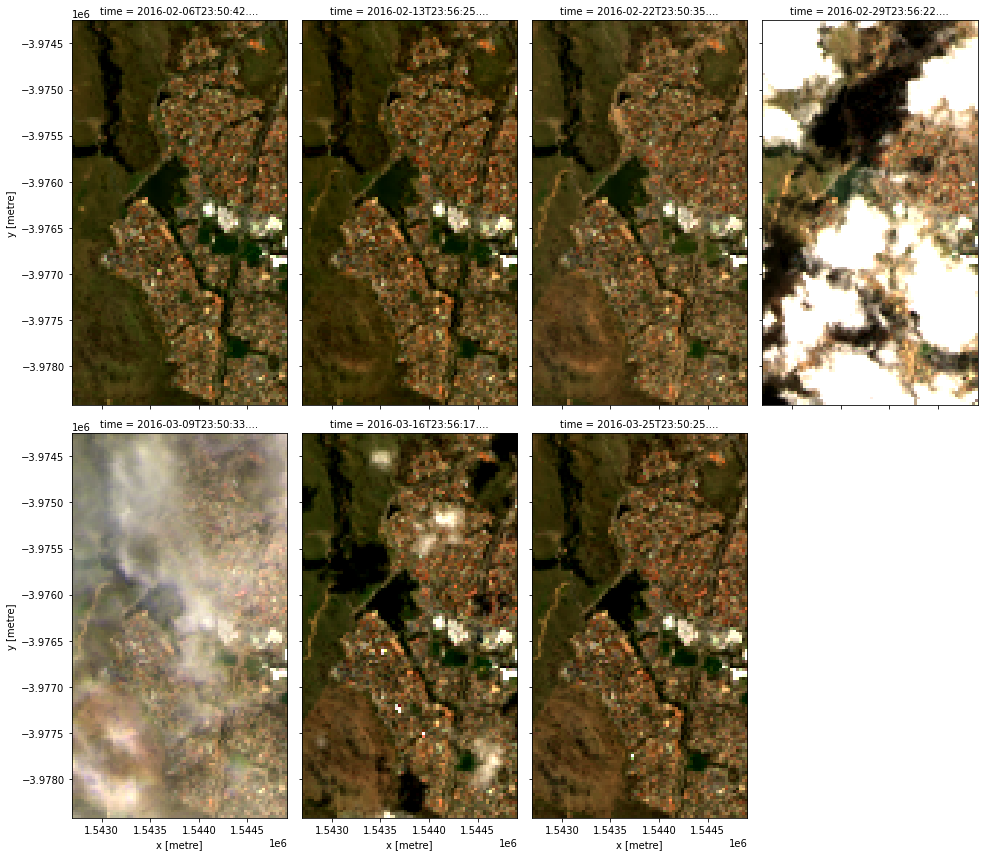

In [9]:
rgb(data, col='time', percentile_stretch=(0.05, 0.95))

## Mask data using the original polygon
The data returned from our polygon drill contains data for the bounding box of the extents of the input polygon, not the actual shape of the polygon. 

To get rid of the bits of the image located outside the polygon, we need to mask the data using the original polygon.

In [10]:
# Generate a polygon mask to keep only data within the polygon
# We used the first polygon in 'polygon_to_drill', so we need to mask
# with the same one
mask = xr_rasterize(polygon_to_drill.iloc[[0]], data)

Rasterizing to match xarray.DataArray dimensions (139, 74)


In [11]:
# Now apply the mask
data_masked = data.where(mask)

## Plot time series of masked data
When we plot the masked dataset, we can see that the areas located outside of the polygon have now been masked out (i.e. set to `NaN` or white):

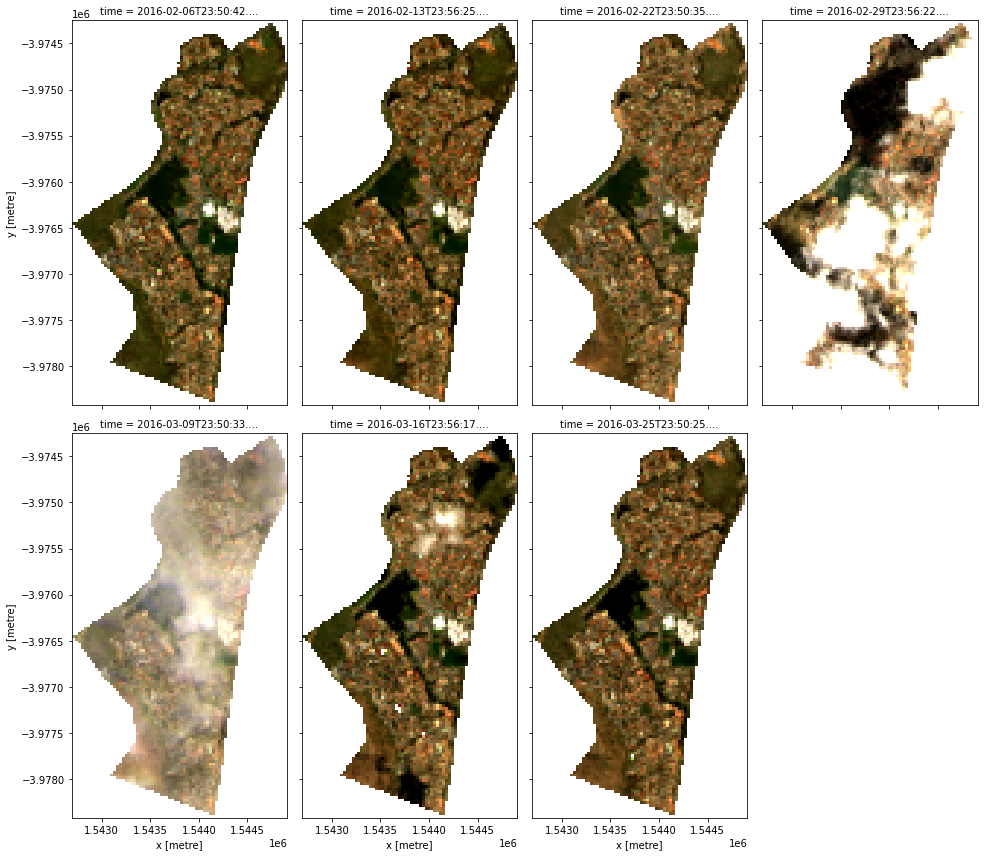

In [12]:
rgb(data_masked, col='time', percentile_stretch=(0.05, 0.95))

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)